In [17]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Mar  5 16:11:06 2020

@author: mkwiatko
"""
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
# import PyQt5
# %matplotlib qt

plt.style.use('dark_background')
#matplotlib.rcParams.keys()
plt.rcParams['figure.figsize'] = (10, 6)
plt.rc('font', size=12)
length = 8
width = 1.5
plt.rcParams['xtick.major.size'] = length
plt.rcParams['ytick.major.size'] = length
plt.rcParams['xtick.major.width'] = width
plt.rcParams['ytick.major.width'] = width

In [18]:
def file2frames(f):
    '''
    reads rogue binary file and returns a list of events
    '''
    ret = []
    fileOffset = 0
    numberOfFrames = 0
    while True:
        try:
            
            file_header = np.fromfile(f, dtype='uint32', count=2, offset=fileOffset)
            payloadSize = int(file_header[0]/4)-1
            payload = np.fromfile(f, dtype='uint32', count=payloadSize, offset=fileOffset+8)
            fileOffset = fileOffset + file_header[0]+4
            
            ret.append(payload)
            numberOfFrames = numberOfFrames + 1 
            
        except Exception: 
            #e = sys.exc_info()[0]
            #print ("Message\n", e)
            print("Events read: %d"%numberOfFrames)
            break
    
    
    return ret
    

In [19]:
def descramble_frame(data):
    '''
    descramble single event from the back upwards
    packet channel enumeration:
        2  - Raw Waveform 0 (uint16)
        ...
        9  - Raw Waveform 7 (uint16)
        10 - Integrals (uint32)
        11 - Position, Intenfity (float64)
    '''
    ret = {}
    #descramble the frame from the back upwards
    i = len(data)
    while i > 0:
        #find the footer ang get the channel number and size
        size_bytes =  data[i-2]
        channel = data[i-1] & 0xf
        
        if channel == 11:
            ret['ProcQuadSel'] = data[i-10] & 0x1
            tmp = np.copy(data[i-8:i-2])
            tmp.dtype = np.float64
            ret['Proc'] = tmp
        if channel == 10:
            ret['IntBlSize'] = 2**((data[i-11] & 0x70000)>>16)
            ret['IntSize'] = (data[i-12] & 0xff)
            ret['IntDelay'] = (data[i-12] & 0xff00) >> 8
            tmp = np.copy(data[i-10:i-2])
            ret['Int'] = tmp
        if channel <= 9 and channel > 1:
            tmp = np.copy(data[i-int(size_bytes/4)-2:i-2])
            tmp.dtype = np.uint16
            ret['Wave%d'%(channel-2)] = tmp
        if channel < 2:
            break
        
        #print('Channel %d, size %d bytes' %(channel, size_bytes))
        i = i - int(size_bytes/4) - 2
        
    return ret


In [20]:
f = "./data3.dat"

fileOffset = 0
numberOfFrames = 0
file_header = np.fromfile(f, dtype='uint32', count=2)
payloadSize = int(file_header[0]/4)-1
events = file2frames(f)


Events read: 390


Events read: 390


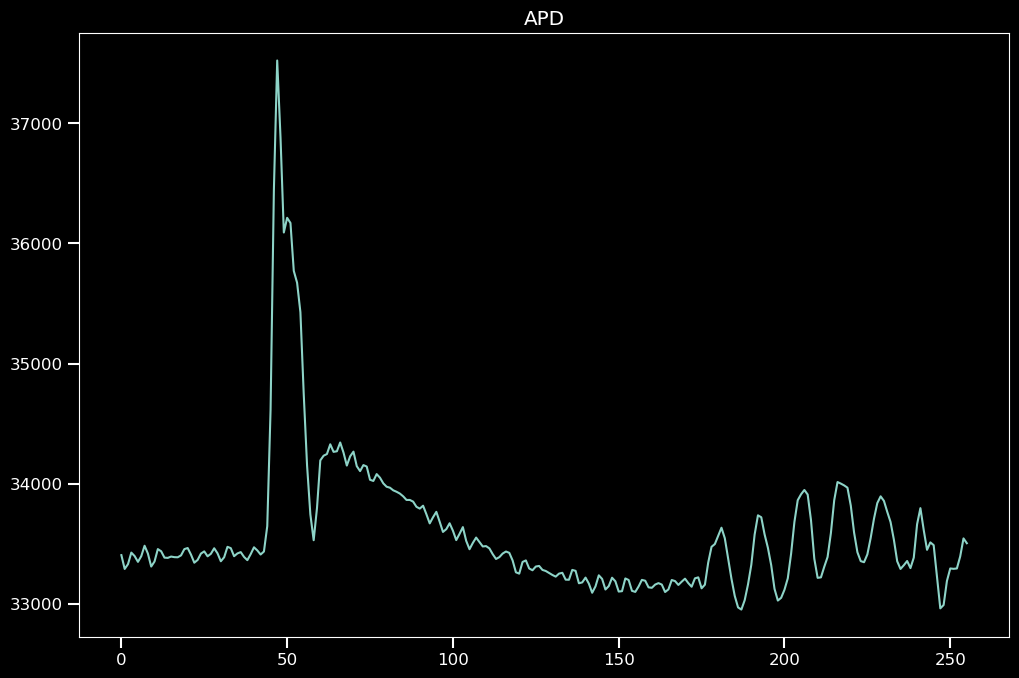

In [21]:
# Read the binary file and find consecutive events

#f = "/u1/mkwiatko/wave8_data/data3.dat"
f = "./data3.dat"

events = file2frames(f)


#Plot APD waveform
wave8data = descramble_frame(events[0])
i=0
channel = 'Wave2'
stop = len(events)
fig, ax = plt.subplots(figsize=(12,8),dpi=100)

plt.title('APD')
x = np.arange(0, len(wave8data[channel]), 1)
line, = ax.plot(x, wave8data[channel])

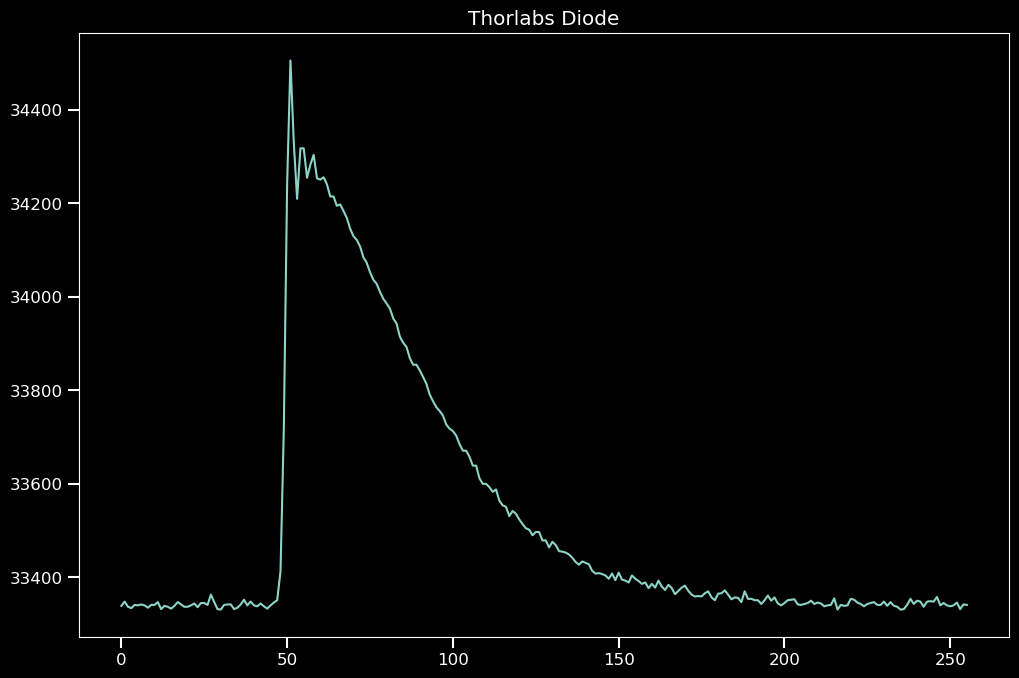

In [22]:
#Plot Thorlabs Diode waveform
wave8data = descramble_frame(events[0])
i=0
channel = 'Wave3'
stop = len(events)
fig, ax = plt.subplots(figsize=(12,8),dpi=100)

plt.title('Thorlabs Diode')
x = np.arange(0, len(wave8data[channel]), 1)
line, = ax.plot(x, wave8data[channel])


In [23]:
print(wave8data)

{'ProcQuadSel': 0, 'Proc': array([ 5.88930000e+04, -9.85023687e-01,  3.08406772e-01]), 'IntBlSize': 8, 'IntSize': 25, 'IntDelay': 45, 'Int': array([  357,    84, 38171, 20281,   163,    52,     7,    37],
      dtype=uint32), 'Wave3': array([33339, 33348, 33337, 33334, 33341, 33340, 33342, 33340, 33335,
       33341, 33341, 33347, 33332, 33339, 33337, 33333, 33339, 33347,
       33342, 33337, 33337, 33340, 33344, 33336, 33345, 33345, 33341,
       33363, 33347, 33332, 33331, 33341, 33342, 33342, 33332, 33335,
       33342, 33352, 33340, 33348, 33340, 33338, 33344, 33338, 33333,
       33340, 33346, 33351, 33413, 33719, 34243, 34506, 34331, 34210,
       34318, 34318, 34255, 34283, 34304, 34254, 34251, 34256, 34241,
       34215, 34215, 34195, 34198, 34184, 34169, 34146, 34130, 34122,
       34108, 34085, 34073, 34053, 34037, 34028, 34011, 33996, 33986,
       33975, 33954, 33943, 33915, 33902, 33893, 33869, 33855, 33855,
       33843, 33829, 33814, 33791, 33777, 33764, 33756, 33746, 33

In [24]:
# Check Wave8-V2 integral calculation, APD
channel = 'Wave2'
#integral = np.sum(wave8data[channel][46:72] - np.mean(wave8data[channel][44-8:44]))
integral = np.sum(wave8data[channel][46:72] - np.trunc(np.mean(wave8data[channel][44-8:44])))
print("integral ",integral)

integral  38171.0


In [25]:
# Check Wave8-V2 integral calculation, Thorlabs diode
channel = 'Wave3'
#integral = np.sum(wave8data[channel][46:72] - np.mean(wave8data[channel][44-8:44]))
integral = np.sum(wave8data[channel][46:72] - np.trunc(np.mean(wave8data[channel][44-8:44])))
print("integral ",integral)

integral  20281.0


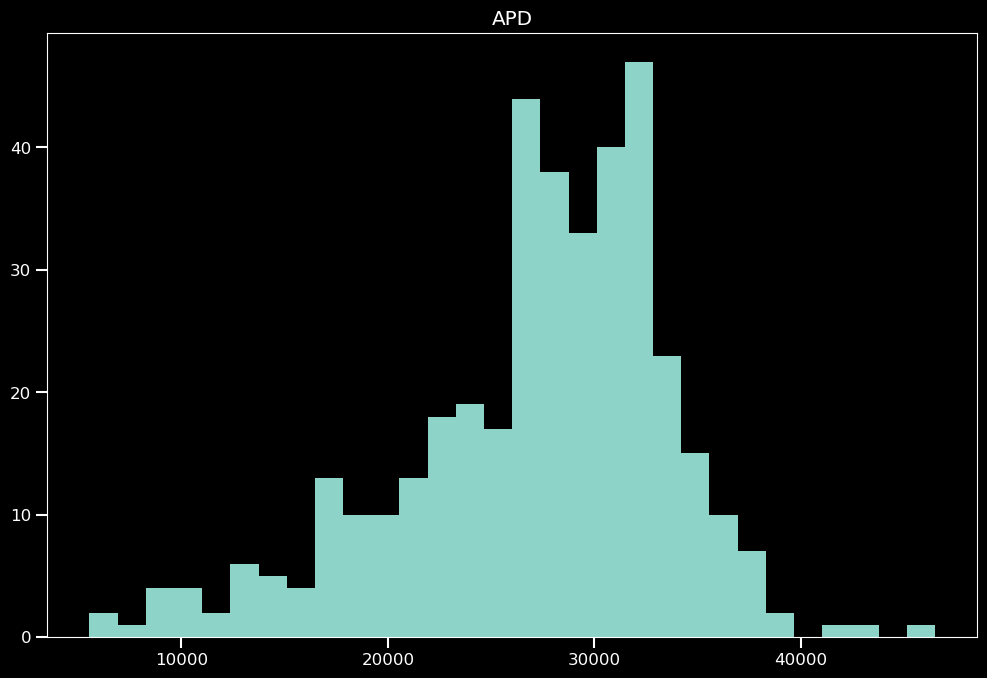

APD standard deviation, fraction 0.2417028517107821


In [26]:
# Plot APD integral histogram and print standard deviation
parameter = 'Int'
intarray = []
for i in range(stop):
    wave8data = descramble_frame(events[i])
    intarray = np.append(intarray,wave8data[parameter][2])

# Plot pump lineout files

fig, ax = plt.subplots(figsize=(12,8),dpi=100)

n_bins = 30
plt.title("APD")
ax.hist(intarray, bins=n_bins)
plt.show()

average = np.mean(intarray)
sigma = np.std(intarray)
print('APD standard deviation, fraction',sigma/average)

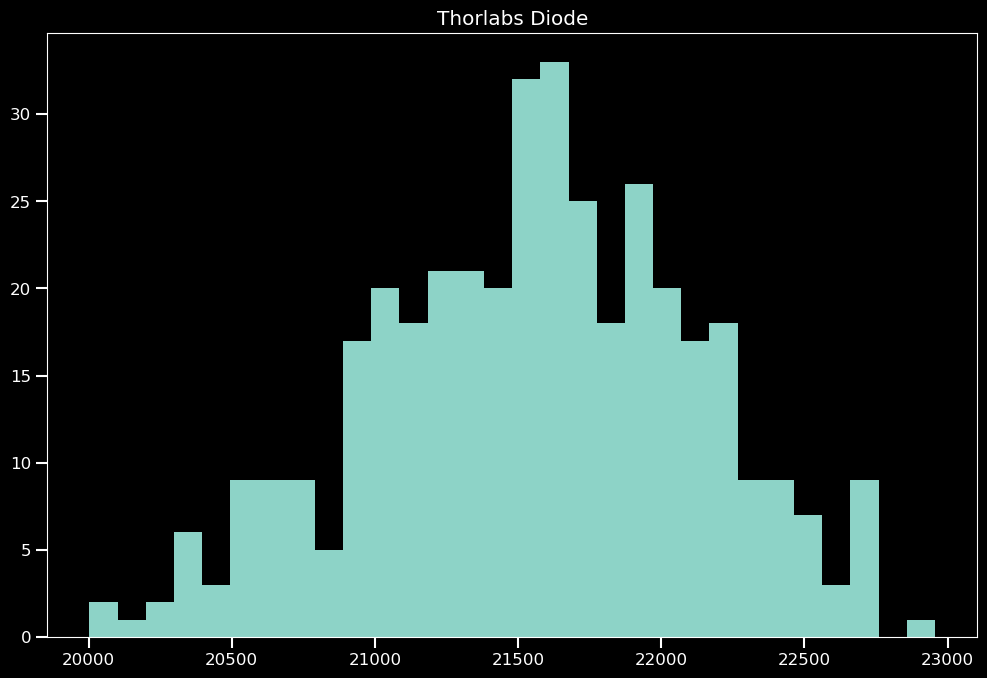

Thorlabs diode standard deviation, fraction 0.026212564140183078


In [27]:
# Plot Thorlabs Diode integral histogram and print standard deviation
parameter = 'Int'
intarray = []
for i in range(stop):
    wave8data = descramble_frame(events[i])
    intarray = np.append(intarray,wave8data[parameter][3])
# print('Wave2 Integrals',intarray)

# Plot pump lineout files

fig, ax = plt.subplots(figsize=(12,8),dpi=100)

n_bins = 30
plt.title("Thorlabs Diode")
ax.hist(intarray, bins=n_bins)
plt.show()

average = np.mean(intarray)
sigma = np.std(intarray)
print('Thorlabs diode standard deviation, fraction',sigma/average)

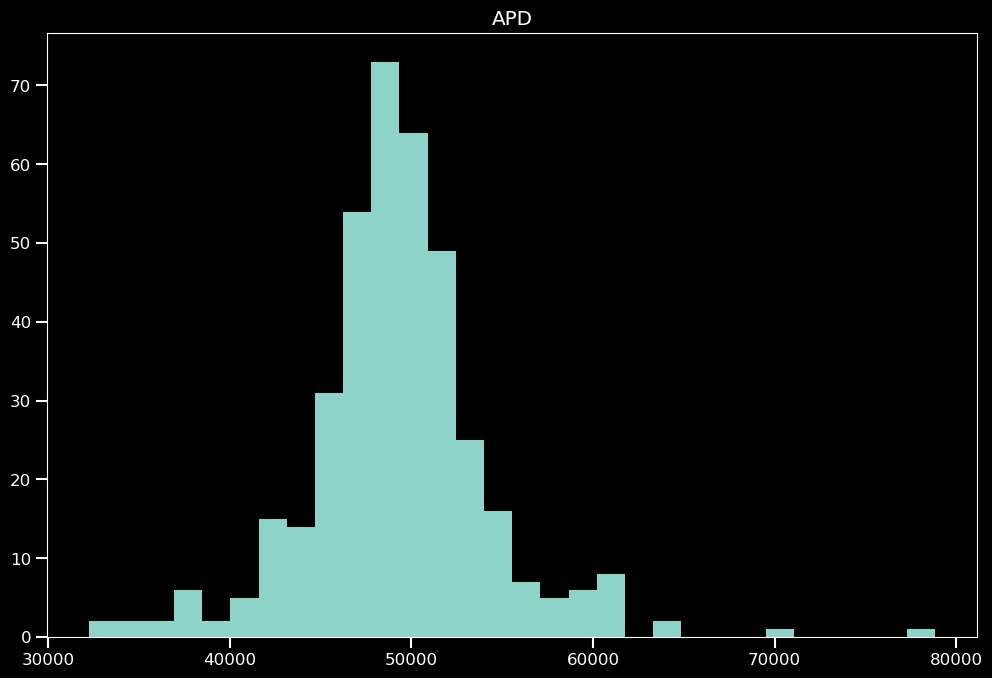

APD standard deviation, fraction 0.10192085899054266


In [28]:
# New Wave8-V2 integral with different window, APD
# Plot APD integral histogram and print standard deviation
channel = 'Wave2'
intarray = []
for i in range(stop):
    wave8data = descramble_frame(events[i])
    integral = np.sum(wave8data[channel][40:110] - np.mean(wave8data[channel][38-20:38]))
    intarray = np.append(intarray,integral)

# Plot histogram
fig, ax = plt.subplots(figsize=(12,8),dpi=100)

n_bins = 30
plt.title("APD")
ax.hist(intarray, bins=n_bins)
plt.show()

average = np.mean(intarray)
sigma = np.std(intarray)
print('APD standard deviation, fraction',sigma/average)

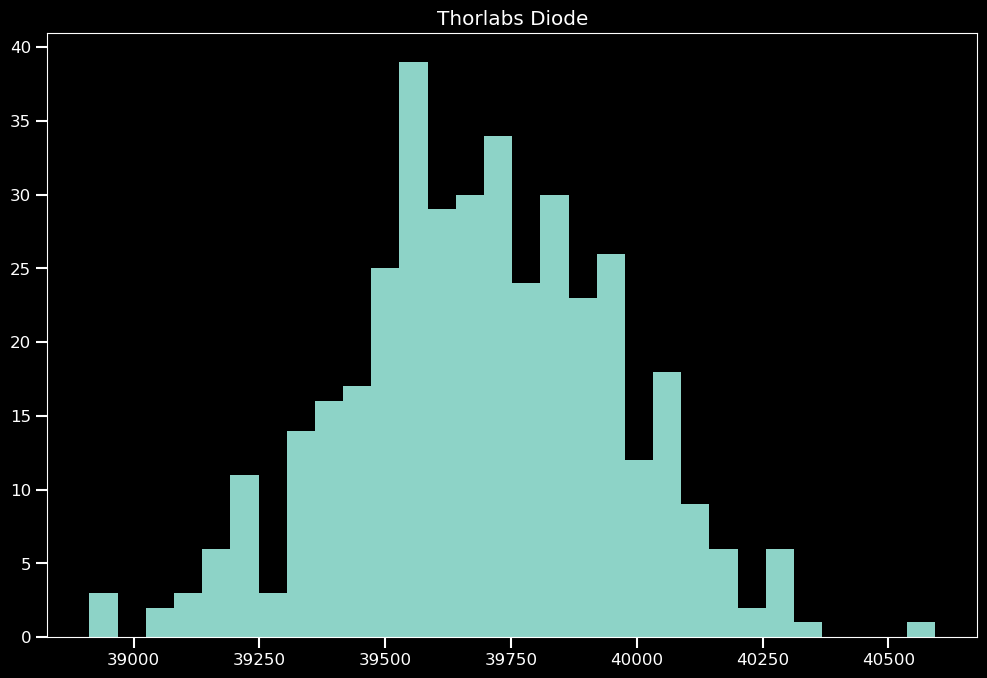

Thorlabs diode standard deviation, fraction 0.0067937160782093


In [29]:
# New Wave8-V2 integral with different window, Thorlabs diode 
# Plot APD integral histogram and print standard deviation
channel = 'Wave3'
intarray = []
for i in range(stop):
    wave8data = descramble_frame(events[i])
    integral = np.sum(wave8data[channel][40:110] - np.mean(wave8data[channel][38-20:38]))
    intarray = np.append(intarray,integral)

# Plot histogram
fig, ax = plt.subplots(figsize=(12,8),dpi=100)

n_bins = 30
plt.title("Thorlabs Diode")
ax.hist(intarray, bins=n_bins)
plt.show()

average = np.mean(intarray)
sigma = np.std(intarray)
print('Thorlabs diode standard deviation, fraction',sigma/average)

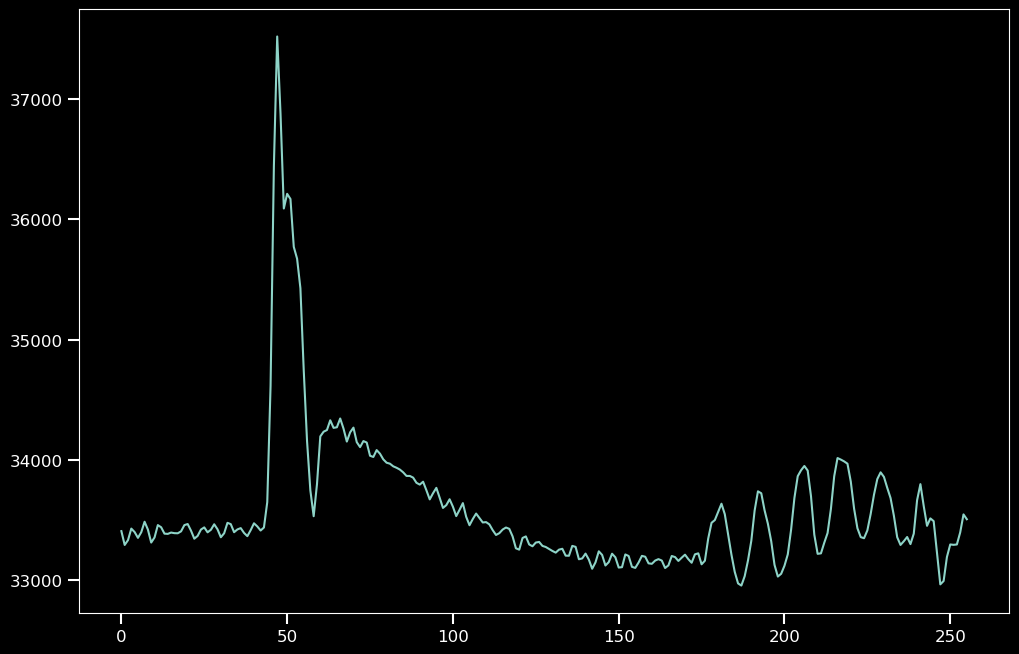

In [30]:
#%%
wave8data = descramble_frame(events[0])
i=0
channel = 'Wave2'
stop = len(events)
fig, ax = plt.subplots(figsize=(12,8),dpi=100)

x = np.arange(0, len(wave8data[channel]), 1)
line, = ax.plot(x, wave8data[channel])


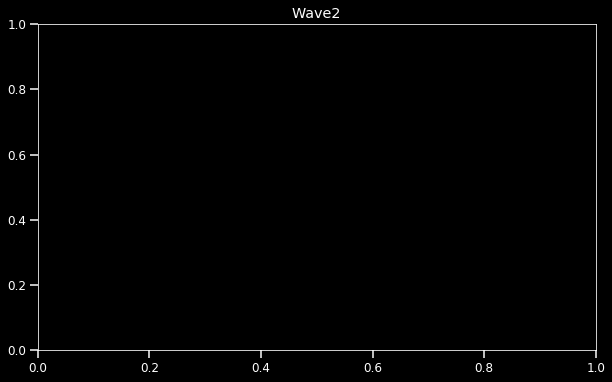

In [31]:
def updatefig(*args):
    global i
    if (i<stop):
        i += 1
    else:
        i = 0
    wave8data = descramble_frame(events[i])
    line.set_ydata(wave8data[channel])  # update the data.
    return line,


ani = animation.FuncAnimation(fig=fig, func=updatefig, interval=1)


plt.title(channel)
plt.show()
